# Learn and evaluate a Regression Model
* Author: Johannes Maucher
* Last Update: 26.11.2020

## Goal
This notebook shall demonstrate the implementation of a complete Data Mining Process from data access to model evaluation and interpretation.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/crispIndall.png" style="width:600px" align="center">

The steps of the *Cross Industry Standard Process for Datamining (CRISP)* are depicted above. Each of these steps can be quite complex. In the current notebook however, a simple example is used to provide you a glimpse of
* each of the crisp phases
* the basics of Python packages used in the crisp process.


## Python Packages for Data Mining and Machine Learning

For implementing the entire Data Mining process chain in Python the following Python packages are commonly used:
* [numpy](http://www.numpy.org) and [scipy](https://www.scipy.org) for efficient datastructures and scientific calculations
* [pandas](https://pandas.pydata.org) for typical data science tasks, such as data access, descriptive statistics, joining of datasets, correlation analysis, etc.
* [matplotlib](https://matplotlib.org), [seaborn](https://seaborn.pydata.org/) and [Bokeh](https://bokeh.pydata.org/en/latest/) for visualisation
* [scikit-learn](https://scikit-learn.org/stable/) for conventional Machine Learning, i.e. all but Deep Neural Networks
* [tensorflow](https://www.tensorflow.org) and [keras](https://keras.io) for Deep Neural Networks

### Scikit-Learn
For conventional Machine Learning scikit-learn provides a comprehensive bunch of algorithms and functions. The basic concepts of scikit-learn are:

* it is primarily built on Numpy. In particular internal and external data structures are [Numpy Arrays](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html).
* All algorithms, which somehow transform data belong to the **Transformer**-class, e.g. *PCA, Normalizer, StandardScaler, OneHotEncoder*, etc. These transformers are trained by applying the `.fit(traindata)`-method. Once they are trained, there `.transform(data)`-method can be called in order to transform *data*. If the data, used for training the transformer, shall be transformed immediately after training, the `.fit_transform(data)`-method can be applied.
* All Machine Learning algorithms for supervised and unsupervised learning belong to the **Estimator** class, e.g. *LogisticRegression, SVM, MLP, Kmeans*, etc. These estimators are trained by applying the
`.fit(trainfeatures)`- or `.fit(trainfeatures,trainlabels)`-method. The former configuration is applied for unsupervised-, the latter for supervised learning. Once an estimator is trained, it can be applied for clustering, classification or regression by envoking the `.predict(data)`-method. 
* At their interfaces all **Transformers** and **Estimators** apply *Numpy Arrays*.

## Crisp Process in a few lines of code

### Business Understanding

In this example, structured data is available from a .csv file. Data has been collected by a U.S. insurance company. For 1339 clients the following features are contained:
* age
* sex
* smoker
* Body-Mass-Index (BMI)
* Number of children
* living region
* annual charges 

<p style="color:red">The goal is to learn a model, which predicts annual charges of clients from the other 5 features.</p>

In [1]:
#!conda install -y seaborn

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
from warnings import filterwarnings
filterwarnings("ignore")
np.set_printoptions(precision=3)

### Access Data from .csv file
For accessing data [pandas provides comfortable interfaces](https://pandas.pydata.org/docs/reference/io.html) to a wide range of different data formats, such as csv, Excel, Json, SQL, HDF5 and many others. 

Data of this example is available in a csv-file, which can be accessed as follows:

In [3]:
data="../Data/insurance.csv"
insurancedf=pd.read_csv(data,na_values=[" ","null"])
insurancedf.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Understand Data

At the very beginning of each datamining task one should try to understand the given data. This task comprises:
- determine how *clean* the data is: Are there missing values, type-errors, value-errors (outliers), etc. 
- determine descriptive statistics
- investigate correlations

*Data visualistion* can help to clarify these questions.

**Determine Type of Data:**

<img src="https://maucher.home.hdm-stuttgart.de/Pics/dataTypes.png" width="400" align="center">

In this example features *sex*, *smoker* and *region* are nominal. All other features are numerical.

#### Numeric features:
For numeric variables standard descriptive statistics such as mean, standard-deviation, quantiles etc. are calculated:

In [4]:
insurancedf.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### Categorical Features:
For non-numeric features the possible values and their count can be calculated as follows:

In [5]:
catFeats=['sex','smoker','region']
for cf in catFeats:
    print("\nFeature %s :"%cf)
    print(insurancedf[cf].value_counts())
    


Feature sex :
male      676
female    662
Name: sex, dtype: int64

Feature smoker :
no     1064
yes     274
Name: smoker, dtype: int64

Feature region :
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


#### Some visualization:
The standard Python visualization library is [matplotlib](https://matplotlib.org). Many other packages integrate and/or extend matplotlib's capabilities. For example [pandas integrates matplotlib's plot() function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html), such that this function can be invoked on dataframe-objects. 

Text(0, 0.5, 'Annual Charges (USD)')

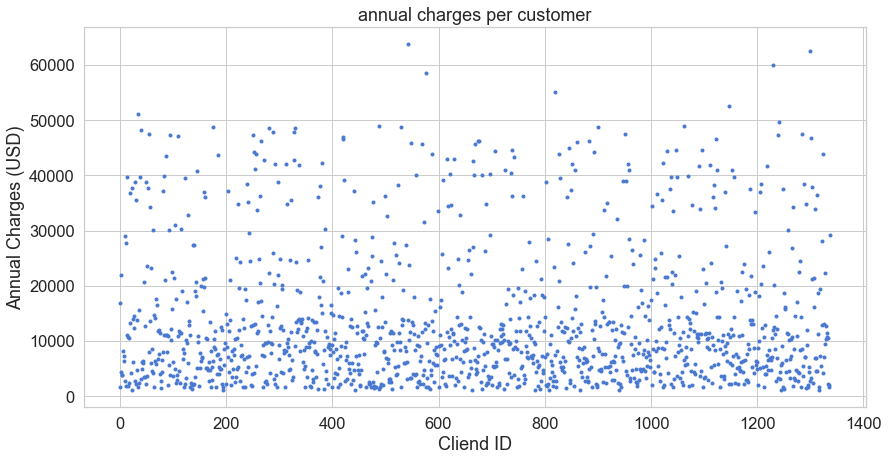

In [6]:
ax=insurancedf["charges"].plot(figsize=(14,7),title="annual charges per customer",
                            marker=".",linestyle="None")
ax.set_xlabel("Cliend ID")
ax.set_ylabel("Annual Charges (USD)")

Analysing the distribution of single attributes helps to understand data. For example it helps to detect outliers. Outliers should be removed from the data, since they may yield disturbed models. Moreover, knowing the univariate distribution may help us in determining necessary preprocessing steps, such as standardization. For classification tasks, the distribution of the class-labels within the training set is a critical point. In the case of extremely unbalanced label-distributions under- or oversampling can be applied for balancing. 

Univariate distributions can be visualized by e.g. histograms, boxplots or violinplots as demonstrated below in the code-cells below:

Among other [plot-kinds](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) boxplots can be generated for dataframe-columns:

<AxesSubplot:>

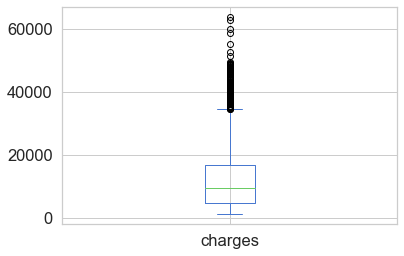

In [7]:
insurancedf["charges"].plot(kind="box")

Above, the *Pandas* `plot()`-function, which applies *Matplotlib* `plot()`-function is applied for generating the Box-plot. *Seaborn* is another visualisation lib for Python, which is particularly dedicated for statistical visualisations. E.g. it provides more functions to visualize data-distributions and -correlations. Below, a seaborn-*violinplot* is generated: 

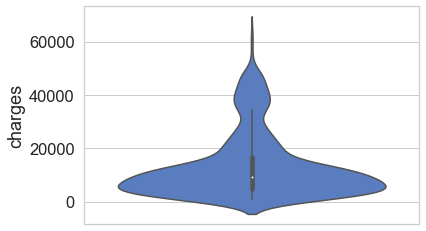

In [8]:
sns.violinplot(y=insurancedf["charges"])
plt.show()

### Preprocess Data

#### Transformation of non-numeric Features
Non-numeric features must be transformed to a numeric representation. For this we apply the `LabelEncoder` from scikit-learn, which belongs to the class of *Transformers*:

In [9]:
from sklearn.preprocessing import LabelEncoder
for cf in catFeats:
    insurancedf[cf] = LabelEncoder().fit_transform(insurancedf[cf].values)

In [10]:
insurancedf.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


#### One-Hot-Encoding of nominal Features

For **non-binary nominal features** a transformation into a numeric value is not sufficient, because algorithms interpret integers as ordinal data. Therefore non-binary nominal features must be **One-Hot-Encoded**. For columns of pandas dataframes the `get_dummies()`-function does the job. In the code-cell below the columns are reordered after One-Hot-Encoding, such that the attribute, which shall be predicted (charges) remains the last column:

In [11]:
insurancedfOH=pd.get_dummies(insurancedf,columns=["region"])
insurancedfOH.head()

,age,sex,bmi,children,smoker,charges,region_0,region_1,region_2,region_3
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [12]:
ch=insurancedfOH["charges"]
insurancedfOH.drop(labels=['charges'], axis=1, inplace = True)
insurancedfOH.insert(len(insurancedfOH.columns), 'charges', ch)
insurancedfOH.head()

,age,sex,bmi,children,smoker,region_0,region_1,region_2,region_3,charges
0,19,0,27.900,0,1,0,0,0,1,16884.92400
1,18,1,33.770,1,0,0,0,1,0,1725.55230
2,28,1,33.000,3,0,0,0,1,0,4449.46200
3,33,1,22.705,0,0,0,1,0,0,21984.47061
4,32,1,28.880,0,0,0,1,0,0,3866.85520


```{note} 
Theory says that nominal features must be One-Hot-encoded. However, in practice prediction-accuracy may be better if One-Hot-encoding is not applied. In order to find out, which option is better, both variants must be implemented and evaluated. Below, the non-One-Hot-Encoded dataset `insurancedf` is applied for modelling. Apply also the One-Hot-encoded dataset `insurancedfOH` and determine, which variant performs better.
```

#### Scaling of data
Except decision trees and ensemble methods, which contain decision trees, nearly all machine learning algorithms require features of similar scale at the input. Since the value ranges of practical data can be very different a corresponding scaling must be performed in the preprocessing chain. The most common scaling approaches are *normalization (MinMax-scaling)* and *standardization*.

**Normalization:** In order to normalize feature *x* it's minimum $x_{min}$ and maximum $x_{max}$ must be determined. Then the normalized values $x_n^{(i)}$ are calculated from the original values $x^{(i)}$ by

$$
x_n^{(i)}=\frac{x^{(i)}-x_{min}}{x_{max}-x_{min}}.
$$

The range of normalized values is $[0,1]$. A problem of this type of scaling is that in the case of outliers the value range of non-outliers may be very small. 

**Standardization:** In order to standardize feature *x* it's mean value $\mu_x$ and standard deviation $\sigma_x$ must be determined. Then the standardized values $x_s^{(i)}$ are calculated from the original values $x^{(i)}$ by

$$
x_s^{(i)}=\frac{x^{(i)}-\mu_x}{\sigma_x}
$$

All standardized features have zero mean and a standard deviation of one.

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

normalizer = MinMaxScaler()
normalizer.fit(insurancedf)
insurancedfNormed = normalizer.transform(insurancedf)
print("Min-Max Normalized Data:")
insurancedfNormed

Min-Max Normalized Data:


array([[0.022, 0.   , 0.321, ..., 1.   , 1.   , 0.252],
       [0.   , 1.   , 0.479, ..., 0.   , 0.667, 0.01 ],
       [0.217, 1.   , 0.458, ..., 0.   , 0.667, 0.053],
       ...,
       [0.   , 0.   , 0.562, ..., 0.   , 0.667, 0.008],
       [0.065, 0.   , 0.265, ..., 0.   , 1.   , 0.014],
       [0.935, 0.   , 0.353, ..., 1.   , 0.333, 0.447]])

In [14]:
standardizer = StandardScaler()
standardizer.fit_transform(insurancedf)
insurancedfStandardized = standardizer.transform(insurancedf)
print("Standardized Data:")
insurancedfStandardized

Standardized Data:


array([[-1.439, -1.011, -0.453, ...,  1.971,  1.344,  0.299],
       [-1.51 ,  0.99 ,  0.51 , ..., -0.507,  0.438, -0.954],
       [-0.798,  0.99 ,  0.383, ..., -0.507,  0.438, -0.729],
       ...,
       [-1.51 , -1.011,  1.015, ..., -0.507,  0.438, -0.962],
       [-1.296, -1.011, -0.798, ..., -0.507,  1.344, -0.93 ],
       [ 1.552, -1.011, -0.261, ...,  1.971, -0.467,  1.311]])

```{note}
As can be seen above, both transformers must be fitted to data by applying the `fit()`-method. Within this method the parameters for the transformation must be learned. These are the columnwise `min` and `max` in the case of the `MinMaxScaler` and the columnwise `mean` and `standard-deviation` in the case of the `StandardScaler`. Once these transformers are fitted (i.e. the parameters are learned), the `transform()`-method can be invoked for actually transforming the data. It is important, that in the context of Machine Learning, the `fit()`-method is only invoked for the training data. Then the fitted transformer is applied to transform **training- and test-data**. It is not valid to learn individual parameters for test-data, since in Machine Learning we pretend test-data to be unknown in advance. 
```

### Modelling
In this example a regression-model shall be learned, which can be applied to estimate the annual charges, given the other 6 features of a person. Since we also like to evaluate the learned model, we have to split the set of all labeled data into 2 disjoint sets - one for training and the other for test.

```{note}
Since the goal of this section is to keep things as simple as possible, we neglect One-Hot-Encoding and Scaling here. In an offline experiment it has been shown, that for this data and the applied ML-algorithm, the two transformations yield no significant performance difference.
```

In [15]:
from sklearn.model_selection import train_test_split

Split input-features from output-label:

In [16]:
X=insurancedf.values[:,:-1] # all features, which shall be applied as input for the prediction
y=insurancedf.values[:,-1]  # annual charges, i.e. the output-label that shall be predicted

Note that in the code cell above, the `values`-attribute of pandas dataframes has been invoked. This attribute contains only the data-part of a pandas-dataframe. The format of this data-part is a numpy-array. I.e. the variables `X`and `y` are numpy-arrays:

Split training- and test-partition:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=674353)

First 5 rows of the training-partition:

In [18]:
X_train.shape

(936, 6)

In [19]:
X_test.shape

(402, 6)

In [20]:
X_test[:5,:]

array([[34.   ,  1.   , 42.13 ,  2.   ,  0.   ,  2.   ],
       [63.   ,  1.   , 36.765,  0.   ,  0.   ,  0.   ],
       [19.   ,  1.   , 27.835,  0.   ,  0.   ,  1.   ],
       [26.   ,  1.   , 27.265,  3.   ,  0.   ,  0.   ],
       [19.   ,  1.   , 28.7  ,  0.   ,  0.   ,  3.   ]])

In scikit-learn a model is learned by calling the `fit(X,y)`-method of the corresponding algorithm-class. The arguments $X$ and $y$ are the array of input-samples and corresponding output-labels, respectively.

In [21]:
from sklearn.linear_model import LinearRegression
linreg=LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression()

In the same way as `LinearRegression` has been applied in the code cell above, any regression algorithm, provided by [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) can be imported and applied. Even conventional feed forward neural networks such as the [Multi Layer Perceptron (MLP) for Regression](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) are provided.

### Evaluation of Regression Models

Once the model has been learned it can be applied for predictions. Here the model output for the test-data is calculated:

In [22]:
ypred=linreg.predict(X_test)

Next, for the first 10 persons of the test-partition the prediction of the model and the true charges are printed:

In [23]:
for pred, target in zip(ypred[:10],y_test[:10]):
    print("Predicted Charges: {0:2.2f} \t True Charges: {1:2.2f}".format(pred,target))

Predicted Charges: 11095.91 	 True Charges: 5124.19
Predicted Charges: 16603.37 	 True Charges: 13981.85
Predicted Charges: 2309.15 	 True Charges: 1635.73
Predicted Charges: 5442.41 	 True Charges: 4661.29
Predicted Charges: 2042.54 	 True Charges: 1253.94
Predicted Charges: 17979.28 	 True Charges: 15170.07
Predicted Charges: 4628.66 	 True Charges: 1674.63
Predicted Charges: 9427.40 	 True Charges: 11534.87
Predicted Charges: 7228.12 	 True Charges: 7173.36
Predicted Charges: 13749.31 	 True Charges: 11946.63


In [24]:
print("Minimum predicted charges: ",ypred.min())
print("Maximum predicted charges: ",ypred.max())

Minimum predicted charges:  374.82948018863317
Maximum predicted charges:  40015.51238363403


In [25]:
ypred=np.clip(ypred,a_min=0,a_max=None)

Regression models can be scored by a variety of metrics. [Regression scores in scikit-learn](http://scikit-learn.org/stable/modules/model_evaluation.html) are 

* mean absolute error (MAE)
* mean squared error (MSE)
* median absolute error (MEDE)
* coefficient of determination ($R^2$) 

If $y_i$ is the predicted value for the i.th element and $r_i$ is it's true value, then these metrics are defined as follows:

$$
\begin{array}[lcl]
 NMAE & = &   \frac{1}{N}\sum\limits_{i=1}^N |y_i-r_i| \\
 MSE & = &   \frac{1}{N}\sum\limits_{i=1}^N (y_i-r_i)^2  \\
 MEDE & = &  median\left( \; |y_i-r_i|, \; \forall \; i \; \in [1,..,N]\right) \\
\end{array}
$$

$$
R^2  =  1- \frac{SS_e}{SS_r}, \quad \mbox{ with } SS_e=\sum_{i=1}^N(r_i-y_i)^2, \quad  SS_r=\sum_{i=1}^N(r_i-\overline{r})^2 \quad \mbox { and } \quad \overline{r}=\frac{1}{N} \sum_{i=1}^N r_i
$$

Another frequently used regression metric is the **Root Mean Squared Logarithmic Error (RMSLE)**, which is caluclated as follows:

$$
RMSLE = \sqrt{\frac{1}{N} \sum\limits_{i=1}^N(\ln(r_i)-\ln(y_i))^2}
$$

For RMSLE there is no explicit scoring function in scikit-learn, but it can be easily computed via the NMSE-function. The RMSLE is well suited for the case that the error (i.e. the difference between $y_i$ and $r_i$) increases with the values of $r_i$. Then large errors at high values of $r_i$ are weighted less by RMSLE.

[scikit-learn provides a bunch of metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) for evaluation classification-, regression- and clustering models. For this task we apply the `mean_absolute_error`:

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error,  median_absolute_error

In [27]:
def determineRegressionMetrics(y_test,y_pred,title=""):
    mse = mean_squared_error(y_test, y_pred)
    mad = mean_absolute_error(y_test, y_pred)
    rmsle=np.sqrt(mean_squared_error(np.log(y_test+1),np.log(y_pred+1)))# +1 for avoiding log(0) 
    r2=r2_score(y_test, y_pred)
    med=median_absolute_error(y_test, y_pred)
    print(title)
    print("Mean absolute error =", round(mad, 2))
    print("Mean squared error =", round(mse, 2))
    print("Median absolute error =", round(med, 2))
    print("R2 score =", round(r2, 2))
    print("Root Mean Squared Logarithmic Error =",rmsle)

In [28]:
determineRegressionMetrics(y_test,ypred)


Mean absolute error = 4123.7
Mean squared error = 37079224.06
Median absolute error = 2459.38
R2 score = 0.76
Root Mean Squared Logarithmic Error = 0.4861243589626347


### Visualisation

For all test-datasets the true-charges are plotted versus the predicted charges. The blue line indicates `predicted=true`:

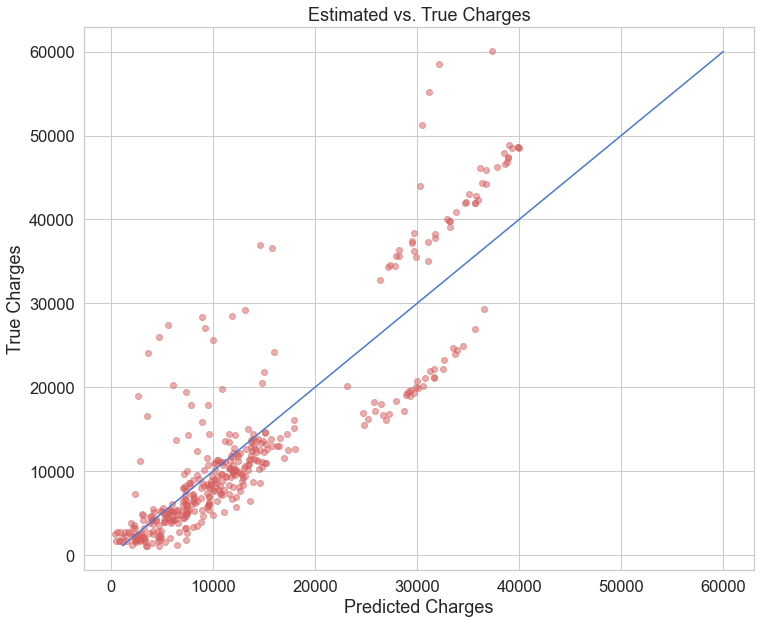

In [29]:
plt.figure(figsize=(12,10))
plt.plot(ypred,y_test,"ro",alpha=0.5)
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])
plt.xlabel("Predicted Charges")
plt.ylabel("True Charges")
plt.title("Estimated vs. True Charges")
plt.show()

Finally, we split smokers from non-smokers and analyse the model's prediction for both partitions:

In [30]:
y_test_smoker=y_test[X_test[:,4]==1]
y_pred_smoker=ypred[X_test[:,4]==1]

In [31]:
y_test_nonsmoker=y_test[X_test[:,4]==0]
y_pred_nonsmoker=ypred[X_test[:,4]==0]

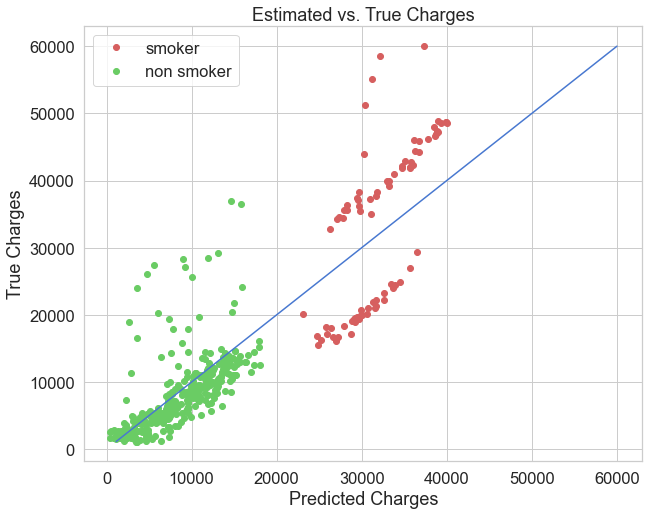

In [32]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_smoker,y_test_smoker,"ro",label="smoker")
plt.plot(y_pred_nonsmoker,y_test_nonsmoker,"go",label="non smoker")
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])
plt.xlabel("Predicted Charges")
plt.ylabel("True Charges")
plt.title("Estimated vs. True Charges")
plt.legend()
plt.show()